# **Understanding self-attention**

### Math and intuition behind self-attention

In [1]:
import torch

In [3]:
torch.manual_seed(1337)
""" 
Time represents the number of tokens in a sequence.
We need each token to be aware of each other. So the t'th token should be aware of all the precedding tokens.
For a simpler understanding lets look at it this way - The easiest way for a token to communicate or be aware of its prev token is to take average of all the elements that came before it.

For this we will take the `channels C` from the prev tokens at `time T`. Channels are like information for the token at T. 
Averaging all those will give some sort of a Feature Vector that summarizes token at T. But this type of communation is extremely lossy, we will loose the information about their order. We will recover it later.
"""


B, T, C = 4, 8, 2 # Batch, Time, Channel
x = torch.randn(B, T, C)
x.shape

torch.Size([4, 8, 2])

#### Version 1

In [ ]:
# bag of words
# Version 1:
xbow = torch.zeros((B, T, C))
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] #(t, C) prev : everything and upto to t token in batch b
        xbow[b, t] = torch.mean(xprev, 0) # averaging everthing previous and getting One dim vecotr stored in BOW

In [7]:
x

tensor([[[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]],

        [[ 1.3488, -0.1396],
         [ 0.2858,  0.9651],
         [-2.0371,  0.4931],
         [ 1.4870,  0.5910],
         [ 0.1260, -1.5627],
         [-1.1601, -0.3348],
         [ 0.4478, -0.8016],
         [ 1.5236,  2.5086]],

        [[-0.6631, -0.2513],
         [ 1.0101,  0.1215],
         [ 0.1584,  1.1340],
         [-1.1539, -0.2984],
         [-0.5075, -0.9239],
         [ 0.5467, -1.4948],
         [-1.2057,  0.5718],
         [-0.5974, -0.6937]],

        [[ 1.6455, -0.8030],
         [ 1.3514, -0.2759],
         [-1.5108,  2.1048],
         [ 2.7630, -1.7465],
         [ 1.4516, -1.5103],
         [ 0.8212, -0.2115],
         [ 0.7789,  1.5333],
         [ 1.6097, -0.4032]]])

In [8]:
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

When we run `xbow[0]` we can notice that except the first row, all other rows are the averages of all previous rows. This is because each row is computed as the average of all previous tokens, ensuring that future tokens do not influence the current token's representation.

This can be compared with the original `x` tensor:
```python
# *Original X* : 
tensor([[[ 0.1808, -0.0700],
         [-0.3596, -0.9152],
         [ 0.6258,  0.0255],
         [ 0.9545,  0.0643],
         [ 0.3612,  1.1679],
         [-1.3499, -0.5102],
         [ 0.2360, -0.2398],
         [-0.9211,  1.5433]],])

# *Xbow* : 
tensor([[[ 0.1808, -0.0700],
         [-0.0894, -0.4926],
         [ 0.1490, -0.3199],
         [ 0.3504, -0.2238],
         [ 0.3525,  0.2355],
         [ 0.1021,  0.0542],
         [ 0.0614, -0.0183],
         [ 0.0283,  0.1923]],])
```

But the method that we used to compute `xbow` is inefficient due to the for loop. Here's how we can do it more efficiently using matrix multiplication and a weight matrix `wei`.

sample example for understand:

```python
import torch
torch.manual_seed(1337)

a = torch.ones(3,3)
b = torch.randint(0, 10, (3,2)).float()
c = a@b

print("-"*30)
print(f"matrix a:\n{a}")
print("-"*30)
print(f"matrix b:\n{b}")
print("-"*30)
print(f"matrix c:\n{c}")
print("-"*30)
```

```txt
output:
------------------------------
matrix a:
tensor([[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]])
------------------------------
matrix b:
tensor([[9., 2.],
        [8., 9.],
        [1., 6.]])
------------------------------
matrix c:
tensor([[18., 17.],
        [18., 17.],
        [18., 17.]])
------------------------------
```

**💡 torch's tril function we can get lower triangular matrix and it can be helpul to get the sum of previous numbers upto n**
**Here's how....**

```python
import torch
torch.manual_seed(1337)

a = torch.tril(torch.ones(3,3))
b = torch.randint(0, 10, (3,2)).float()
c = a@b

print("-"*30)
print(f"matrix a:\n{a}")
print("-"*30)
print(f"matrix b:\n{b}")
print("-"*30)
print(f"matrix c:\n{c}")
print("-"*30)
```
```txt
output:
------------------------------
matrix a:
tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])
------------------------------
matrix b:
tensor([[1., 9.],
        [0., 1.],
        [9., 8.]])
------------------------------
matrix c:
tensor([[ 1.,  9.],
        [ 1., 10.],
        [10., 18.]])
------------------------------
```

**But since our traget is to get avg upto token t at time T we can distribute the rows in matrix A such that their avg sum is 1**
```python
a = torch.tril(torch.ones(3,3))
a = a / torch.sum(a, 1 , keepdim=True)
b = torch.randint(0, 10, (3,2)).float()
c = a@b

print("-"*30)
print(f"matrix a:\n{a}")
print("-"*30)
print(f"matrix b:\n{b}")
print("-"*30)
print(f"matrix c:\n{c}")
print("-"*30)
```
```txt
output:
------------------------------
matrix a:
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
------------------------------
matrix b:
tensor([[8., 6.],
        [9., 4.],
        [8., 3.]])
------------------------------
matrix c:
tensor([[8.0000, 6.0000],
        [8.5000, 5.0000],
        [8.3333, 4.3333]])
------------------------------
```


#### Version 2

In [ ]:
# Version 2:
wei = torch.tril(torch.ones(T, T)) # our A matrix
wei = wei/ wei.sum(1, keepdim=True)
xbow2 = wei @ x # (T, T) @ (B, T, C) ------> (B, T, C)
torch.allclose(xbow, xbow2) # These are infact the same

True

In [24]:
print(f"Using the previous for loop method:\n{xbow[0]}","\n")
print(f"Using the previous for torch.tril method:\n{xbow2[0]}")


Using the previous for loop method:
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]]) 

Using the previous for torch.tril method:
tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])


We can Also leverage softmax to make the weights more dynamic and data-dependent. Basically we will replace the 0's in the lower triangular matrix with -infinity so that after applying softmax those positions will become 0 and everything else will be positive weights, evenly distributed and adding upto 1. Here's how...

```python
tril = torch.tril(torch.ones(T, T))
```
```txt
tensor([[1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
```

```python
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
```
```txt
tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf],
        [0., 0., 0., 0., 0., 0., 0., 0.]])
```

```python
wei = F.softmax(wei, dim = -1)
```
```txt
tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])
```



#### Version 3: use Softmax

In [25]:
# Version 3: use Softmax
from torch.nn import functional as F

tril = torch.tril(torch.ones(T, T))
wei = torch.zeros((T,T))
wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim = -1)
xbow3 = wei @ x
torch.allclose(xbow, xbow3) # These are infact the same


True

#### Version 4

Before reading the version 4, read the code below this code and then come back to this.

In [ ]:
# version 4/: self-attention
from torch.nn import functional as F
import torch.nn as nn

B, T, C = 4, 8, 32
x = torch.randn(B, T, C)

"""
In self attention, every token will emmit two vectors:
- Query vector (Q): This represents "What am I looking for?"
- Key vector (K): This represents "What am I?"


The dot product of these two gives us the weights (wei)
"""


# Lets see a single head perform self-attention
head_size = 16
key, query = nn.Linear(C, head_size, bias=False), nn.Linear(C, head_size, bias=False) # Linear layer with input = Total information (i.e. how many Channel C) and output = number of heads (head_size)

k = key(x) # (B, T, 16)
q = key(x) # (B, T, 16)

# we take transpose of the last two dimeansions (i.e. T, !6)
wei = q @ k.transpose(-2, -1) # ---> This gives result: (B, T, C) @ (B, C, T) = (B, T, T)

tril = torch.tril(torch.ones(T, T))

# ==========================
# wei = torch.zeros((T,T))
# ==========================

wei = wei.masked_fill(tril==0, float('-inf'))
wei = F.softmax(wei, dim = -1)

# ==========================
# out = wei @ x
# ==========================

# Instead of aggregating x with the weight(wei) we will use the Value Vector
value = nn.Linear(C, head_size, bias=False)
v = value(x)

out = wei @ v # ---> out dimension for Channel will be 16 coz that how many number of heads are used

print(out.shape)
print(wei)

"""
In the output we can see that before `wei` was just a constant, i.e. it was appiled in the same way to all the batch elements.
But now every single batch element will have different `wei` because every single token are different at diff position and so now this is data dependent.
"""

torch.Size([4, 8, 16])
tensor([[[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [7.7444e-02, 9.2256e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.9161e-04, 1.9549e-04, 9.9951e-01, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [4.8137e-05, 6.9968e-04, 1.0766e-03, 9.9818e-01, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [1.4944e-03, 2.4115e-04, 2.7807e-05, 5.6382e-06, 9.9823e-01,
          0.0000e+00, 0.0000e+00, 0.0000e+00],
         [2.4621e-03, 6.4659e-05, 1.3728e-04, 5.4803e-06, 3.0198e-03,
          9.9431e-01, 0.0000e+00, 0.0000e+00],
         [2.4152e-03, 2.5491e-05, 1.1020e-04, 1.0206e-06, 4.9141e-04,
          1.8301e-01, 8.1395e-01, 0.0000e+00],
         [8.5732e-03, 1.5466e-03, 7.8638e-03, 7.6089e-06, 2.2824e-03,
          5.9080e-03, 1.1211e-02, 9.6261e-01]],

        [[1.0000e+00, 0.0000e+00, 0.000

'\nIn the output we can see that before `wei` was just a constant, i.e. it was appiled in the same way to all the batch elements.\nBut now every single batch element will have different `wei` because every single token are different at diff position and so now this is data dependent.\n'

In [9]:
wei[0]

tensor([[1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [1.5476e-03, 9.9845e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [2.4472e-02, 8.9388e-04, 9.7463e-01, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [6.1077e-02, 2.2214e-01, 1.4697e-01, 5.6982e-01, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [7.2049e-04, 3.1659e-04, 3.3480e-02, 1.9180e-03, 9.6356e-01, 0.0000e+00,
         0.0000e+00, 0.0000e+00],
        [5.8347e-03, 2.2413e-02, 8.5964e-03, 7.5137e-02, 8.4527e-03, 8.7957e-01,
         0.0000e+00, 0.0000e+00],
        [3.4006e-03, 1.8311e-03, 7.6658e-04, 1.4987e-03, 1.7798e-02, 6.0924e-03,
         9.6861e-01, 0.0000e+00],
        [3.4540e-03, 9.9582e-04, 2.6909e-04, 1.2191e-03, 2.6857e-03, 1.7982e-03,
         7.7859e-03, 9.8179e-01]], grad_fn=<SelectBackward0>)

---
## <mark><u>Very Important Note</u></mark>:
The above code implentation is a simple `decoder block` that uses self-attention mechanism.
In a `decoder block` the future tokens should not influence the current token's representation. This is achieved by using a causal mask (lower triangular matrix) during the attention computation, ensuring that each token can only attend to itself and previous tokens, not future ones. This is crucial for autoregressive models like GPT, where the model generates text one token at a time and should not have access to future tokens during training or inference.

The code part that creates the causal mask and applies it to the attention weights is as follows:

```python
wei = wei.masked_fill(tril==0, float('-inf'))
```


But in an Encoder block the masking will not be done and all the tokens will aware of each other, even the future tokens too. To achieve this the given code line will not be used.

---

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

In [11]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
wei = q @ k.transpose(-2, -1) * head_size**-0.5

In [13]:
k.var(), q.var(), wei.var()

(tensor(0.8943), tensor(0.9735), tensor(0.8851))

In [14]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5]), dim=-1)

tensor([0.1925, 0.1426, 0.2351, 0.1426, 0.2872])

In [15]:
torch.softmax(torch.tensor([0.1, -0.2, 0.3, -0.2, 0.5])*8, dim=-1) # gets too peaky, converges to one-hot

tensor([0.0326, 0.0030, 0.1615, 0.0030, 0.8000])

---

## We will be using this concept of self-attention extensively while building GPT from scratch.

using the same script of bigram.py but with slight changes.

In [1]:
import torch
from torch.nn import functional as F
import torch.nn as nn
print("mps : ",torch.backends.mps.is_available()) # Should return True

mps :  True


In [5]:
INPUT_DATA_FILE = r'/Users/kunal/My Works/Learning/GptFromScratch/data/input/tinyStoriesData.txt'
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
BATCH_SIZE = 4 # how many independent sequences will we process in parallel? 
BLOCK_SIZE = 8 # what is the maximum context length for predictions? ---> 256 to predict all range of tokens from 0-255
MAX_ITERS = 1000
EVAL_INTERVAL = 300
LEARNING_RATE = 3e-4
EVAL_ITERS = 200

# --------------
N_EMBD = 24
NUM_HEAD = 2
# ----Ever Head is of dim = n_embd//n_head => 486//8 = 64


N_LAYER = 6 # Number of transformer block
DROPOUT = 0.2 # 20% dropout, Regularizetion to prevent overfitting  

In [6]:
# INPUT_DATA_FILE = r'/Users/kunal/My Works/GptFromScratch/data/input/tinyStoriesData.txt'
# DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
# BATCH_SIZE = 64 # how many independent sequences will we process in parallel? 
# BLOCK_SIZE = 256 # what is the maximum context length for predictions? ---> 256 to predict all range of tokens from 0-255
# MAX_ITERS = 5000
# EVAL_INTERVAL = 300
# LEARNING_RATE = 3e-4
# EVAL_ITERS = 200

# # --------------
# N_EMBD = 496
# NUM_HEAD = 8
# # ----Ever Head is of dim = n_embd//n_head => 486//8 = 64


# N_LAYER = 6 # Number of transformer block
# DROPOUT = 0.2 # 20% dropout, Regularizetion to prevent overfitting  

In [7]:
torch.manual_seed(1337)

In [8]:
with open(INPUT_DATA_FILE, "r", encoding="utf-8") as f:
    text = f.read()


In [9]:
chars = sorted(list(set(text)))
vocab_size = len(chars)
print("".join(chars))
print(f"Calculated Vocab Size : {vocab_size}")

	
 !"#$%&'()*+,-./0123456789:;<=>?@ABCDEFGHIJKLMNOPQRSTUVWXYZ[\]_`abcdefghijklmnopqrstuvwxyz{|}~ ¡¢£¤¥¦§¨©ª«¬­®¯°±²³´µ¶·¸¹º»¼½¾¿ÂÃÄÅÉÊÑÒáâãäåæçèéîïðŒœŠšŸŽžƒˆ˜–‘’‚“”„†‡•…‰‹›€™
Calculated Vocab Size : 174


In [10]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

In [11]:
# Train on a 70% subset of the data for faster training.
data_divider = int(0.7 * len(text))
data = torch.tensor(encode(text[:data_divider]), dtype=torch.long, device=DEVICE)

# Split this data into 90% training and 10% validation
split_point = int(0.9 * len(data))
train_data = data[:split_point]
val_data = data[split_point:]

In [12]:
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - BLOCK_SIZE, (BATCH_SIZE,))
    x = torch.stack([data[i:i+BLOCK_SIZE] for i in ix])
    y = torch.stack([data[i+1:i+BLOCK_SIZE+1] for i in ix])
    # x, y = x.to(device), y.to(device)
    return x, y


### Single Head Attention implementation

In [13]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(N_EMBD, head_size, bias=False)
        self.query = nn.Linear(N_EMBD, head_size, bias=False)
        self.value = nn.Linear(N_EMBD, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(BLOCK_SIZE, BLOCK_SIZE)))

        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):
        # input of size (batch, time-step, channels)
        # output of size (batch, time-step, head size)
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs) -> hs: head_size
        q = self.query(x) # (B,T,hs)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5 # (B, T, hs) @ (B, hs, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)

        # -------------------------
        wei = self.dropout(wei)
        # -------------------------

        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,hs)
        out = wei @ v # (B, T, T) @ (B, T, hs) -> (B, T, hs)
        return out

### Multi-Head Attention

In [14]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_head, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_head)])
        self.proj = nn.Linear(N_EMBD, N_EMBD)
        self.dropout = nn.Dropout(DROPOUT) 
         

    def forward(self, x):
        out =  torch.cat([h(x) for h in self.heads], dim = -1)
        out = self.proj(out)

        return out

### Feed Forward Network

Before using FFN, when we only used MHA, the model's capacity to learn complex patterns was limited. MHA allows the model to focus on different parts of the input sequence simultaneously, capturing various relationships and dependencies. However, we went way too fast to calculate the logits and the model did not have much to think about those token. Hence we introduce Feed Forward Network (FFN) to enhance the model's ability to learn complex patterns and representations.

In [15]:
class FeedForward(nn.Module):
    """This is a single linear layer followed by non-linearity"""
    def __init__(self, n_embd):
        super().__init__()


        """
        As per the paper of GPT2, they implemented the FFN as:
        The outer layer was of size 512 and their inner layer was of size 2048 i.e. outer layer = 4 x inner layer

        Hence when going inside the FFN we will use the dimension = n_embd and the inner layer will be 4 x n_embd
        """


        self.net = nn.Sequential(
            nn.Linear(n_embd, 4*n_embd),
            nn.GELU(),
            nn.Linear(4*n_embd, n_embd), # ---> this particular layer is the projection layer that goes back in the residual pathway       
            # dropout is something that is added right before the residual connection gets back in the residual pathway
            nn.Dropout(DROPOUT) 
        )
    def forward(self, x):
        return self.net(x)

### Block Structure

<!-- 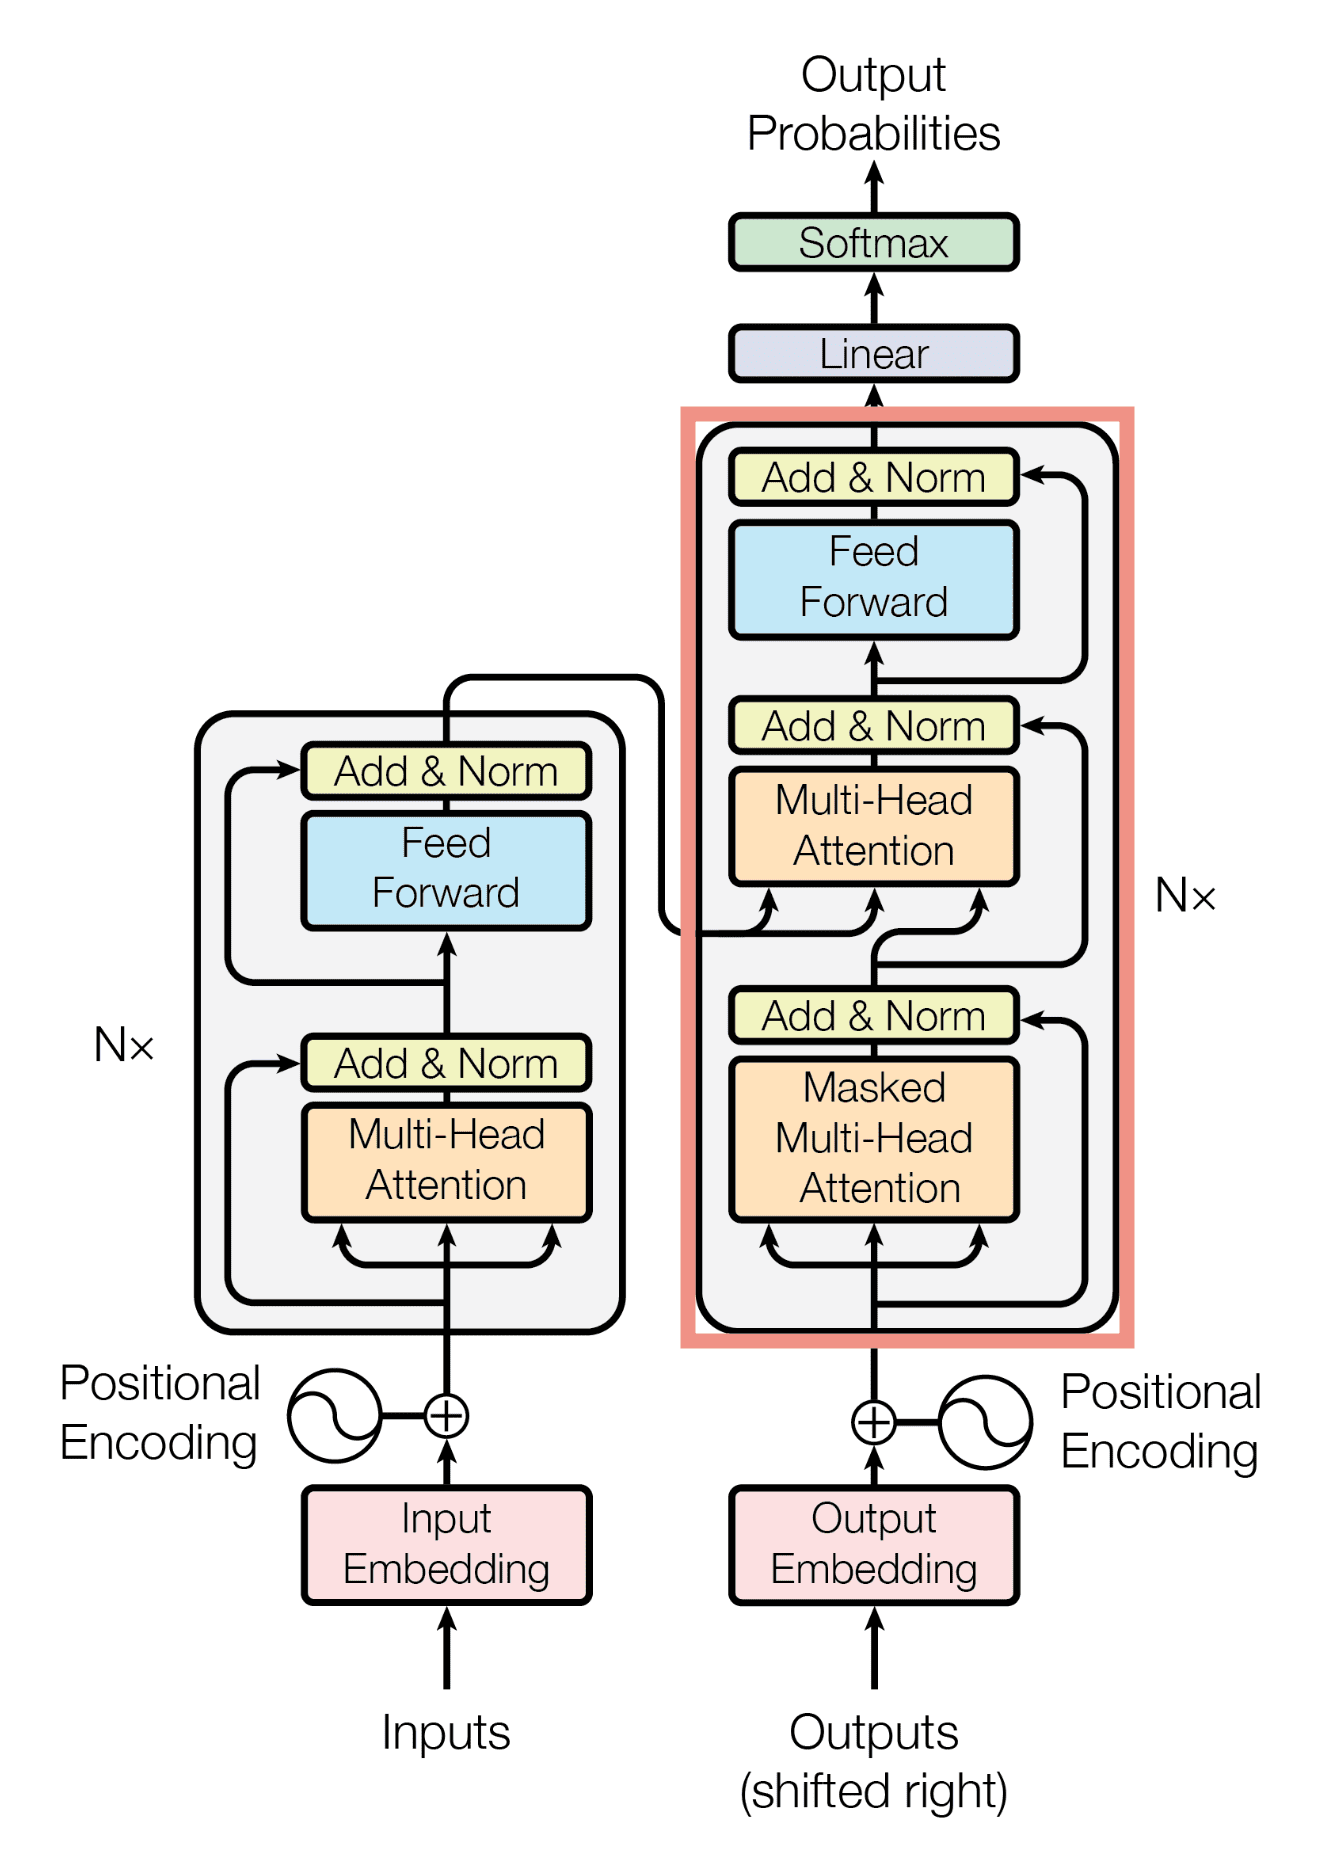 -->
<img src="./assets/gpt2.png" width="30%" alt="Resized image">


Here we will combine Multi-Head Attention (MHA) and Feed Forward Network (FFN) into a single block structure, as marked in the above image. This block will serve as the fundamental building unit for our transformer model. The block will first apply MHA to the input, allowing the model to attend to different parts of the sequence. Following this, the output of MHA will be passed through the FFN, which will help in learning complex patterns and representations.

In [16]:
class Block(nn.Module):
    """A transformer Block comprising of Attention, FFN and BLM"""
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd//n_head
        self.sa = MultiHeadAttention( n_head, head_size)
        self.fwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)
    
    def forward(self, x):
        # In `x + self.sa(x)` or `x + self.fwd(x)` the `x + _` denotes that we fork from x (i.e. residuals are added at the Self-attention step and FFN step) 
        # Layer normalization is applied immediately on x
        x = x + self.sa(self.ln1(x))
        x = x + self.fwd(self.ln2(x))
        return x

---

**NOTE :** The reason for adding residual connection can be read after the cell from where the training ends.

---

### Enhanced BLM

In [17]:
import torch.nn as nn
from torch.nn import functional as F

 
class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()  
        # =================== Changes ==============================
        self.token_embedding_table = nn.Embedding(vocab_size, N_EMBD) #---> now this will not give us logits instead it will give us token_embeddings

        self.position_embedding_table = nn.Embedding(BLOCK_SIZE, N_EMBD)

        # self.sa_head = Head(N_EMBD) # ---> Single Self attention head
        # ----------------------- MHA + FFN (Single) -----------------------------------
        # self.sa_head = MultiHeadAttention(NUM_HEAD, N_EMBD//4) # ---> i.e. 4 heads of 8 dimensional self-attention. Hence the total size would be 4*8= 32 which is the original embedding layer.
        # self.fwd = FeedForward(N_EMBD)
        # ------------------------------------------------------------------------------

        # -------- Using Multiple Blocks --------------
        # self.blocks  = nn.Sequential(
        #     Block(N_EMBD, NUM_HEAD),
        #     Block(N_EMBD, NUM_HEAD),
        #     Block(N_EMBD, NUM_HEAD),
        #     nn.LayerNorm(N_EMBD)
        # )

        # compact implementation
        self.blocks = nn.Sequential(*[Block(N_EMBD, n_head=NUM_HEAD) for _ in range(N_LAYER)])


        # ==========================================================
        
        # To go from token embeddings to logits we will create linear layer
        self.lm_head = nn.Linear(N_EMBD, vocab_size)
    
    def forward(self, idx, targets= None):
        B, T = idx.shape

        # targets and idx are (B,T) tensor of integer
        tok_embd = self.token_embedding_table(idx) # returns an embeddng row from the embedding table
                                                    # this consists of (B, T, C) -> (Batch, Time, Channel)

        pos_embd = self.position_embedding_table(torch.arange(T, device = DEVICE)) # ---> (T, C)

        # calculate positional embdings for x
        x = pos_embd + tok_embd # (B, T, C)
    
        # =============== MHA + FFN ================
        # calculate multi head self attention for x
        # x = self.sa_head(x)
        # Learn the patterns in the self attention
        # x = self.fwd(x)
        # ==========================================
        
        # USING BLOCKS
        x = self.blocks(x)
        
        logits = self.lm_head(x) #---> (B, T, vocab_size)

        # if target is None then there is no loss to calculate
        if targets is None:
            loss = None
            return logits, loss

        # we de-construct the values because currently our logits are of shape (BTC)
        # and the cross-entrophy fucntion of torch take (BCT) as input
        # Pytorch Cross-Entrophy excepts 'C' at 2nd place
        B, T, C = logits.shape
        logits = logits.view(B*T, C)
        targets = targets.view(B*T)

        loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        """ Bsically the function takes (B, T) index and generates (B, T+1), (B, T+2), (B, T+3), .... upto max_new_tokens"""
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):

            # crop idx to the last block_size tokens
            idx_cond = idx[:, -BLOCK_SIZE:]

            # get the prediction
            logits, loss= self(idx_cond) # calling the forward function defined above, but notice that the target param is not mentioned, that's because it is optional.


            # focusing only on the last time step
            logits = logits[:,-1,:] # Becomes (B,C)

            probs = F.softmax(logits, dim=-1)

            # samples from distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)

            # append samples to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) #(B, T+1)
        return idx
    
# m = BigramLanguageModel(vocab_size)
model = BigramLanguageModel(vocab_size)
m = model.to(DEVICE)


---
<mark>Misc:</mark>

<p>
Print number of Parameters in the model
</p>

```python
print(f"Number of parameters in the model: {sum(p.numel() for p in model.parameters())/1e6} Million")
```

---


In [18]:
print(f"Number of parameters in the model: {sum(p.numel() for p in model.parameters())/1e6} Million")

Number of parameters in the model: 0.05163 Million


In [19]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(EVAL_ITERS)
        for k in range(EVAL_ITERS):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

In [20]:
optimizer = torch.optim.AdamW(m.parameters(), lr=LEARNING_RATE)

### Training the Model

In [21]:
for iter in range(MAX_ITERS):

    # every once in a while evaluate the loss on train and val sets
    if iter % EVAL_INTERVAL == 0 or iter == MAX_ITERS - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=DEVICE)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))

step 0: train loss 5.7201, val loss 5.7117
step 300: train loss 2.9200, val loss 2.9206
step 600: train loss 2.6963, val loss 2.6921
step 900: train loss 2.5692, val loss 2.5802
step 999: train loss 2.5641, val loss 2.5665
	ind his. bwe war t.eIigor sovlod hercitca!ty t be woeef it amm \ar
chea pt 
emersskee ith hhitve arrphtil s woslsad ba sdoIoud bstav 
koted.ok Blele ctorcowand w owey hothe we  te,ad she 
e thais xpysa bt. the wi t 
car

ovot srimy. He.cowthk e wanlinre st ée veaw he ane bdde tanilyy. fale 
c wiil brenhe s seluaee spyl bieinse nuubouumey t opot tose ryerhavovee he "gieed gomw io the il osanavl  t Hhipgmutasb u a l lsetacr t peke Hlrutlle sany halrrntorpyg"T'my. w wiptinepw the hgse t Saso . wima


---


Since we are adding mulitple Blocks of connections the results cannot be seen to be very good, this is an optimization problem and it can be solved in two ways:

1. **Adding residual connections at each sub-layer (MHA and FFN)**. <p><i>So this will look like `x + MHA(x)` and `x + FFN(x)` respectively.</i>

    ```python
    # Before Residual Connection
    x = self.sa(x)
    x = self.fwd(x)

    # Before Residual Connection
    x = x + self.sa(x)
    x = x + self.fwd(x)

    ```

2. **Layer Normalization** : Normalizing the inputs to each sub-layer (MHA and FFN) to have zero mean and unit variance. This helps stabilize the training process and allows for deeper networks. (Layer Normalization means that we normalize the rows in `Batch` dimension). Here we implemet Pre-layer Normalization.

    ```python
    # Before Layer Normalization
    x = self.sa(x)
    x = self.fwd(x)

    # After Layer Normalization
    x = x + self.sa(self.ln1(x))
    x = x + self.fwd(self.ln2(x))
    ```

    The layer normalization is applied in the **Block** just before passing the input to lm_head, after the final block.

---

Testing on the using some random input from the training data

In [7]:
text[:500]

'One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with it because it was sharp. Lily wanted to share the needle with her mom, so she could sew a button on her shirt.\n\nLily went to her mom and said, "Mom, I found this needle. Can you share it with me and sew my shirt?" Her mom smiled and said, "Yes, Lily, we can share the needle and fix your shirt."\n\nTogether, they shared the needle and sewed the button on Lily\'s shirt. It was not difficult for them b'

In [ ]:
test = "Can you share it with me and"

context = torch.zeros(encode([test]), dtype=torch.long, device=DEVICE)
print(decode(m.generate(context, max_new_tokens=500)[0].tolist()))
